In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import utils
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from matplotlib import cm
import pickle

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id_idx = 1
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
experiment_id = experiment_ids[experiment_id_idx]
round_ids = ["ARN", "R01", "R02N"]

In [3]:
dtype = torch.float32
device = torch.device('cpu')

In [4]:
(sequences, sequences_unique, counts, log_multinomial_factors, 
 sequences_unique_all, counts_unique) = \
    utils.sequences_from_files_detailed(experiment_id, round_ids)

Extracting sequences from 3 files...
Finished round ARN
Finished round R01
Finished round R02N
Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round ARN...
	Starting round R01...
	Starting round R02N...
Finished


In [38]:
train_valid_idx = torch.load(f'saved/train_test_split/{experiment_id}.pt')
idx_train = train_valid_idx['idx_train']
idx_valid = train_valid_idx['idx_valid']

In [39]:
((sequences_oh, total_reads, log_multinomial_factors), 
 (sequences_valid_oh, total_reads_valid, log_multinomial_factors_valid)) = \
    data_loading.split_train_test(sequences_unique_all, counts_unique, idx_train, idx_valid)

In [40]:
total_reads = total_reads.to(device)
log_multinomial_factors = log_multinomial_factors.to(device)
total_reads_valid = total_reads_valid.to(device)
log_multinomial_factors_valid = log_multinomial_factors_valid.to(device)

In [6]:
with open('./saved/wildtypes_sites.pkl', 'rb') as f:
    wts = pickle.load(f)

wt = wts[experiment_id_idx]
wt_oh = utils.one_hot(wt)

In [136]:
from importlib import reload
reload(energy_models)
reload(utils)
reload(training)

<module 'training' from '/home/scrotti/Aptamer2025py/experiments/../training.py'>

In [137]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_oh[0][0].shape

mu = 0.3
from math import log
gamma_init = -log(mu/(q-1)) + log(1-mu)

Ns0 = energy_models.OverlapEnergy(wt_oh, alpha=gamma_init)
ps = selex_distribution.MultiModeDistribution(energy_models.OverlapEnergy(wt_oh, alpha=0.0), normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [138]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
data_loaders_valid = [data_loading.SelexRoundDataLoader(seq_oh, device=device) for seq_oh in sequences_valid_oh]
n_rounds = len(data_loaders) 

In [139]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

In [140]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.ParamsCallback(save_every=10)]

In [146]:
n_sweeps = 10
max_epochs = 500
lr = 0.01

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               lr=lr, callbacks=callbacks, log_weights=log_weights,
                  log_multinomial_factors=log_multinomial_factors, log_multinomial_factors_valid=log_multinomial_factors_valid,
               data_loaders_valid=data_loaders_valid, total_reads_valid=total_reads_valid)

 0.00%[                                                                                                       …

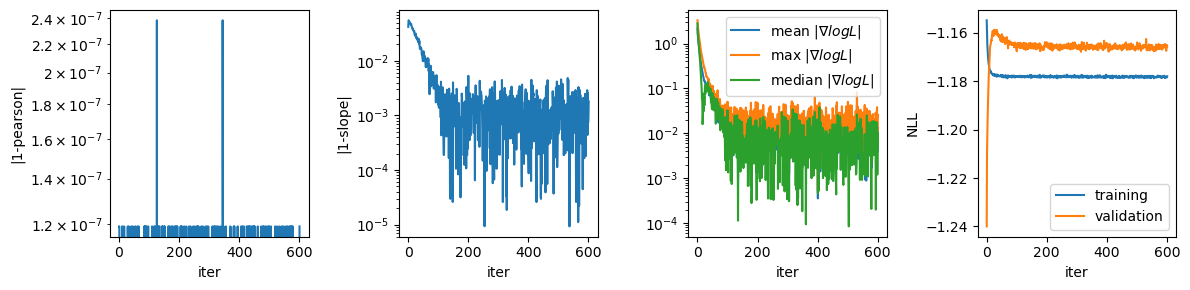

In [147]:
callbacks[0].plot();

In [148]:
n_chains = 10**4
n_sweeps = 1
step = 0.0001

In [149]:
batches = [next(iter(dl)) for dl in data_loaders]

nll_train = - training.estimate_log_likelihood_AIS(model, batches, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)
nll_train

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

1.4558170346386257

In [150]:
batches = [next(iter(dl)) for dl in data_loaders_valid]
nll_valid = - training.estimate_log_likelihood_AIS(model, batches, total_reads_valid, log_multinomial_factors_valid, n_chains, n_sweeps, step)
nll_valid

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

3.5229908929412823

In [151]:
mu = 0.3
q = 4
from math import log
-log(mu/(q-1)) + log(1-mu), Ns0.alpha.item()

(1.9459101490553135, 2.0208895206451416)

In [152]:
model.selection.modes[0].alpha

Parameter containing:
tensor(0.3080, requires_grad=True)

In [153]:
X = sequences_oh[0]
distances = utils.hamming(wt_oh, X)
distances_unique = torch.unique(distances)

In [154]:
logps = - model.selection_energy_at_round(X, 1).detach()

In [155]:
avg_logps_distances = []
std_logps_distances = []
avg_ps_distances = []
std_ps_distances = []
for d in distances_unique:
    idx = distances == d
    avg_logps_distances.append(logps[idx].mean().item())
    std_logps_distances.append(logps[idx].std().item())
    l = torch.exp(logps[idx])
    avg_ps_distances.append(l.mean().item())
    std_ps_distances.append(l.std().item())

/tmp/ipykernel_4100934/648179695.py:8: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  std_logps_distances.append(logps[idx].std().item())
/tmp/ipykernel_4100934/648179695.py:11: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  std_ps_distances.append(l.std().item())


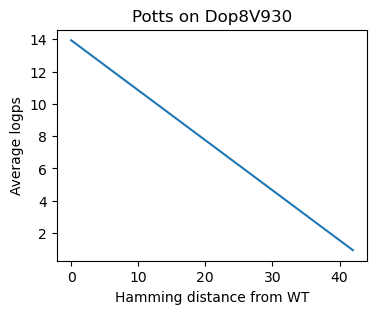

In [133]:
fig, ax = plt.subplots(figsize=(4,3))
ax.errorbar(distances_unique, avg_logps_distances, yerr=std_logps_distances, ecolor='black', markersize=1)
ax.set_xlabel('Hamming distance from WT')
ax.set_ylabel('Average logps')
ax.set_title('Potts on ' + experiment_id);

In [125]:
from importlib import reload
reload(energy_models)
reload(utils)

<module 'utils' from '/home/scrotti/Aptamer2025py/experiments/../utils.py'>

In [133]:
alpha = -2
p = energy_models.OverlapEnergy(wt_oh, alpha)
avg_ovl = p.avg_overlap().detach()
avg_ovl

tensor(1.9424)

In [134]:
chains = training.init_chains(1, 10**3, L, q)[0]
avg_overlaps = []

for it in range(10**3):
    chains, energies = sampling._sample_metropolis(chains, p, 1)
    overlaps = L - utils.hamming(wt_oh, chains).detach()
    avg_overlap = overlaps.mean().item()
    avg_overlaps.append(avg_overlap)

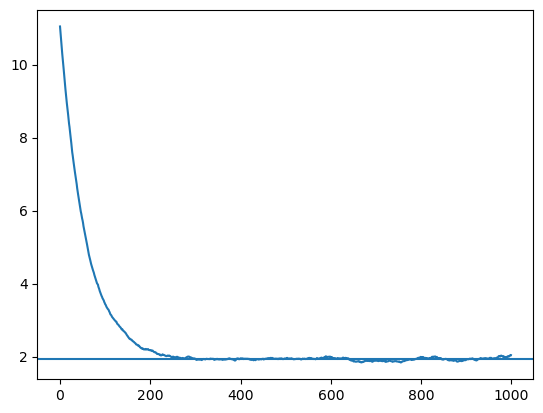

In [135]:
fig, ax = plt.subplots()
ax.plot(avg_overlaps)
ax.axhline(y=avg_ovl)